In [11]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [12]:
# Path to your dataset
data_path = os.path.join('..', '..', 'data', 'processed', 'dl_ready_flights', 'dl_tabular_data.csv')

# Load dataset
df = pd.read_csv(data_path)

print("✅ Loaded data shape:", df.shape)
df.head()


✅ Loaded data shape: (600000, 53)


,FL_DATE,AIRLINE,AIRLINE_DOT,AIRLINE_CODE,DOT_CODE,FL_NUMBER,ORIGIN,ORIGIN_CITY,DEST,DEST_CITY,...,DAY_OF_WEEK_NORM,DEP_HOUR_NORM,MONTH_SIN,MONTH_COS,DAY_OF_WEEK_SIN,DAY_OF_WEEK_COS,DEP_HOUR_SIN,DEP_HOUR_COS,ORIGIN_FLIGHTS,ORIGIN_FLIGHTS_NORM
0,2021-07-25,0.944530,0.944530,1.067426,-1.552522,2.460211,-0.842944,-0.835750,-0.756873,-0.819571,...,1.513621,0.817800,-0.733237,-1.111240,-1.134983,0.871194,-1.181304,0.199712,1.468965,1.468965
1,2019-11-09,-1.266437,-1.266437,-1.397812,-0.453101,-1.314106,-1.059691,-1.101914,1.462173,1.218245,...,1.013834,-1.234219,-0.733237,1.341978,-1.411967,-0.308945,1.383718,0.199712,0.867214,0.867214
2,2023-05-26,0.944530,0.944530,1.067426,-1.552522,-0.453622,-1.049839,-0.940314,-1.585316,-1.495669,...,0.514047,-1.029017,0.688621,-1.111240,-0.635874,-1.255343,1.251075,-0.246307,-0.859627,-0.859627
3,2023-03-23,0.774456,0.774456,0.539160,0.878478,0.530202,-0.567084,-0.512550,0.840840,0.913525,...,0.014260,-1.439421,1.399550,0.115369,0.608882,-1.255343,1.428960,0.678350,-1.143316,-1.143316
4,2022-03-27,1.284679,1.284679,0.891337,0.005880,-1.048896,-0.606493,0.599636,1.264924,1.180155,...,1.513621,-0.208209,1.399550,0.115369,-1.134983,0.871194,0.101207,-1.170964,-0.024023,-0.024023


In [13]:
# Convert DEP_DELAY to numeric (force bad values to NaN)
df['DEP_DELAY'] = pd.to_numeric(df['DEP_DELAY'], errors='coerce')

# Show after fix
print(df['DEP_DELAY'].describe())
print("NaNs in DEP_DELAY after fix:", df['DEP_DELAY'].isna().sum())


count    600000.000000
mean          0.009300
std           1.091749
min          -0.294091
25%          -0.294091
50%          -0.294091
75%          -0.132652
max          53.989702
Name: DEP_DELAY, dtype: float64
NaNs in DEP_DELAY after fix: 0


In [14]:
# First convert to datetime temporarily
df['FL_DATE'] = pd.to_datetime(df['FL_DATE'], errors='coerce')

# Extract numeric date parts
df['FL_MONTH'] = df['FL_DATE'].dt.month
df['FL_DAY'] = df['FL_DATE'].dt.day
df['FL_DOW'] = df['FL_DATE'].dt.dayofweek

# Drop the original datetime column
df = df.drop(columns=['FL_DATE'])


In [ ]:
#  Remove 'CANCELLATION_CODE' column if it exists
if 'CANCELLATION_CODE' in df.columns:
    df = df.drop(columns=['CANCELLATION_CODE'])
    print("'CANCELLATION_CODE' column removed.")
else:
    print(" 'CANCELLATION_CODE' column not found — nothing to remove.")


✅ 'CANCELLATION_CODE' column removed.


In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load your dataset

# Define target and features
target = 'DEP_DELAY'
X = df.drop(columns=[target, 'FL_DATE'], errors='ignore')
y = df[target]

# Keep only numeric features
X = X.select_dtypes(include=[np.number])

# Train/val/test split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Normalize inputs
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)


In [17]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch import nn
import numpy as np

# === FT-Transformer Custom Implementation ===
class FTTransformerCustom(nn.Module):
    def __init__(self, num_features, d_token=64, n_heads=4, n_layers=3, dropout=0.1):
        super().__init__()
        self.cls_token = nn.Parameter(torch.zeros(1, 1, d_token))  # Learnable [CLS] token
        self.tokenizer = nn.Linear(num_features, d_token)  # Linear projection for numeric features

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_token,
            nhead=n_heads,
            dim_feedforward=4 * d_token,
            dropout=dropout,
            activation='gelu',
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        self.head = nn.Linear(d_token, 1)  # Regression output

    def forward(self, x):
        tokens = self.tokenizer(x).unsqueeze(1)  # shape: (B, 1, d_token)
        cls = self.cls_token.expand(x.size(0), -1, -1)
        x = torch.cat([cls, tokens], dim=1)
        encoded = self.transformer(x)
        return self.head(encoded[:, 0])

# === NaN-safe tensor conversion ===
def to_tensor_clean(x):
    if hasattr(x, "to_numpy"):
        x = x.to_numpy()
    x = np.array(x, dtype=np.float32)
    if np.isnan(x).any():
        col_mean = np.nanmean(x, axis=0)
        inds = np.where(np.isnan(x))
        x[inds] = np.take(col_mean, inds[1])
    return torch.tensor(x, dtype=torch.float32)

# === Prepare tensors with NaN handling ===
X_train = to_tensor_clean(X_train)
y_train = to_tensor_clean(y_train).unsqueeze(1)
X_val = to_tensor_clean(X_val)
y_val = to_tensor_clean(y_val).unsqueeze(1)
X_test = to_tensor_clean(X_test)
y_test = to_tensor_clean(y_test).unsqueeze(1)

# === DataLoaders ===
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=512, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=512)

# === Initialize model ===
model = FTTransformerCustom(
    num_features=X_train.shape[1],
    d_token=64,
    n_heads=4,
    n_layers=3,
    dropout=0.1
)


In [18]:
print("🔍 y_train NaNs:", torch.isnan(y_train).sum().item())
print("🔍 y_val NaNs:", torch.isnan(y_val).sum().item())


🔍 y_train NaNs: 0
🔍 y_val NaNs: 0


In [19]:
print("X_train mean:", X_train.mean().item())
print("X_train std:", X_train.std().item())


X_train mean: -4.094601602222525e-10
X_train std: 0.9514720439910889


In [20]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch import nn
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score  # For RMSE and R²

# === FT-Transformer Custom Implementation ===
class FTTransformerCustom(nn.Module):
    def __init__(self, num_features, d_token=64, n_heads=4, n_layers=3, dropout=0.1):
        super().__init__()
        self.cls_token = nn.Parameter(torch.zeros(1, 1, d_token))  # Learnable [CLS] token
        self.tokenizer = nn.Linear(num_features, d_token)  # Linear projection for numeric features

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_token,
            nhead=n_heads,
            dim_feedforward=4 * d_token,
            dropout=dropout,
            activation='gelu',
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        self.head = nn.Linear(d_token, 1)  # Regression output

    def forward(self, x):
        tokens = self.tokenizer(x).unsqueeze(1)           # shape: (B, 1, d_token)
        cls = self.cls_token.expand(x.size(0), -1, -1)    # shape: (B, 1, d_token)
        x = torch.cat([cls, tokens], dim=1)               # shape: (B, 2, d_token)
        encoded = self.transformer(x)                     # shape: (B, 2, d_token)
        return self.head(encoded[:, 0])                   # shape: (B, 1)

# === NaN-safe tensor conversion ===
def to_tensor_clean(x):
    if hasattr(x, "to_numpy"):
        x = x.to_numpy()
    x = np.array(x, dtype=np.float32)
    if np.isnan(x).any():
        col_mean = np.nanmean(x, axis=0)
        inds = np.where(np.isnan(x))
        x[inds] = np.take(col_mean, inds[1])
    return torch.tensor(x, dtype=torch.float32)

# === Prepare tensors ===
X_train = to_tensor_clean(X_train)
X_val = to_tensor_clean(X_val)
X_test = to_tensor_clean(X_test)
y_train = to_tensor_clean(y_train)
y_val = to_tensor_clean(y_val)
y_test = to_tensor_clean(y_test)

# === Fix shape: remove extra dimensions if present ===
y_train = y_train.view(-1, 1)
y_val = y_val.view(-1, 1)
y_test = y_test.view(-1, 1)

# === DataLoaders ===
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=512, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=512)

# === Initialize model ===
model = FTTransformerCustom(
    num_features=X_train.shape[1],
    d_token=64,
    n_heads=4,
    n_layers=3,
    dropout=0.1
)

# === Loss & Optimizer ===
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# === Training loop ===
train_mae, val_mae = [], []

for epoch in range(10):
    model.train()
    for xb, yb in train_loader:
        yb = yb.view(-1, 1)
        pred = model(xb)
        loss = loss_fn(pred, yb)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

    # === Evaluation ===
    model.eval()
    with torch.no_grad():
        train_pred = model(X_train).squeeze().numpy()
        val_pred = model(X_val).squeeze().numpy()
        train_true = y_train.numpy().squeeze()
        val_true = y_val.numpy().squeeze()

        # Metrics
        train_mae_val = np.mean(np.abs(train_pred - train_true))
        val_mae_val = np.mean(np.abs(val_pred - val_true))

        # === Fixed RMSE calculation ===
        train_rmse = np.sqrt(mean_squared_error(train_true, train_pred))
        val_rmse = np.sqrt(mean_squared_error(val_true, val_pred))

        train_r2 = r2_score(train_true, train_pred)
        val_r2 = r2_score(val_true, val_pred)

        train_mae.append(train_mae_val)
        val_mae.append(val_mae_val)

    print(f"Epoch {epoch+1}: "
          f"Train MAE = {train_mae_val:.2f}, Val MAE = {val_mae_val:.2f}, "
          f"Train RMSE = {train_rmse:.2f}, Val RMSE = {val_rmse:.2f}, "
          f"Train R² = {train_r2:.4f}, Val R² = {val_r2:.4f}")


Epoch 1: Train MAE = 0.11, Val MAE = 0.11, Train RMSE = 0.25, Val RMSE = 0.24, Train R² = 0.9485, Val R² = 0.9500
Epoch 2: Train MAE = 0.07, Val MAE = 0.07, Train RMSE = 0.18, Val RMSE = 0.18, Train R² = 0.9715, Val R² = 0.9740
Epoch 3: Train MAE = 0.08, Val MAE = 0.08, Train RMSE = 0.18, Val RMSE = 0.17, Train R² = 0.9731, Val R² = 0.9745
Epoch 4: Train MAE = 0.08, Val MAE = 0.08, Train RMSE = 0.17, Val RMSE = 0.16, Train R² = 0.9755, Val R² = 0.9777
Epoch 5: Train MAE = 0.10, Val MAE = 0.10, Train RMSE = 0.19, Val RMSE = 0.18, Train R² = 0.9703, Val R² = 0.9718
Epoch 6: Train MAE = 0.13, Val MAE = 0.13, Train RMSE = 0.20, Val RMSE = 0.19, Train R² = 0.9682, Val R² = 0.9704
Epoch 7: Train MAE = 0.12, Val MAE = 0.12, Train RMSE = 0.18, Val RMSE = 0.17, Train R² = 0.9727, Val R² = 0.9755
Epoch 8: Train MAE = 0.09, Val MAE = 0.09, Train RMSE = 0.18, Val RMSE = 0.18, Train R² = 0.9715, Val R² = 0.9726
Epoch 9: Train MAE = 0.10, Val MAE = 0.10, Train RMSE = 0.16, Val RMSE = 0.15, Train R² 

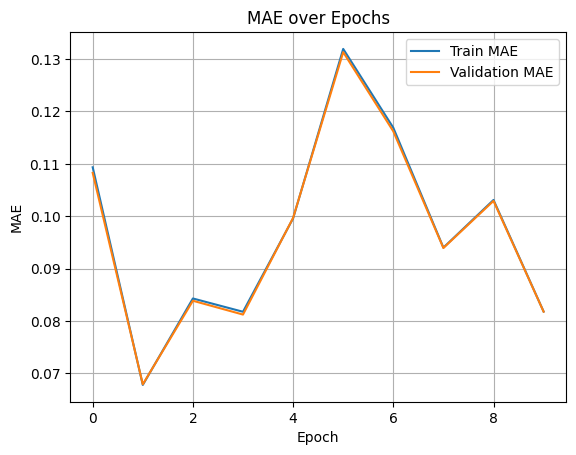

In [21]:
import matplotlib.pyplot as plt

plt.plot(train_mae, label='Train MAE')
plt.plot(val_mae, label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('MAE over Epochs')
plt.legend()
plt.grid(True)
plt.show()


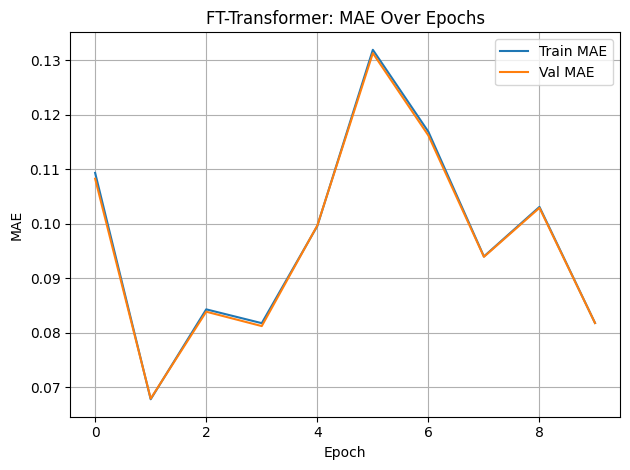

In [22]:
import matplotlib.pyplot as plt

plt.plot(train_mae, label="Train MAE")
plt.plot(val_mae, label="Val MAE")
plt.title("FT-Transformer: MAE Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


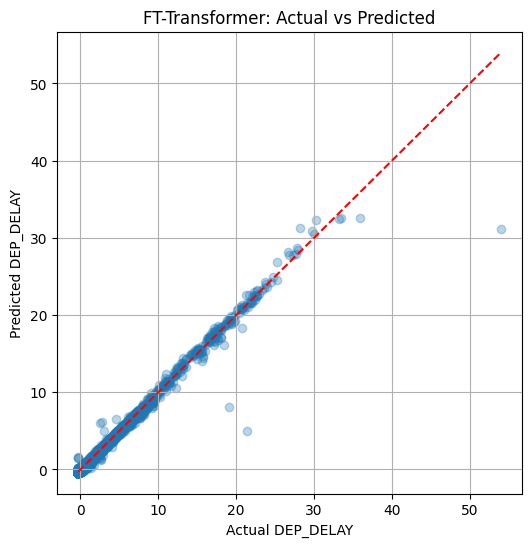

In [23]:
with torch.no_grad():
    y_pred = model(X_test).squeeze().numpy()

plt.figure(figsize=(6, 6))
plt.scatter(y_test.numpy(), y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual DEP_DELAY")
plt.ylabel("Predicted DEP_DELAY")
plt.title("FT-Transformer: Actual vs Predicted")
plt.grid(True)
plt.show()


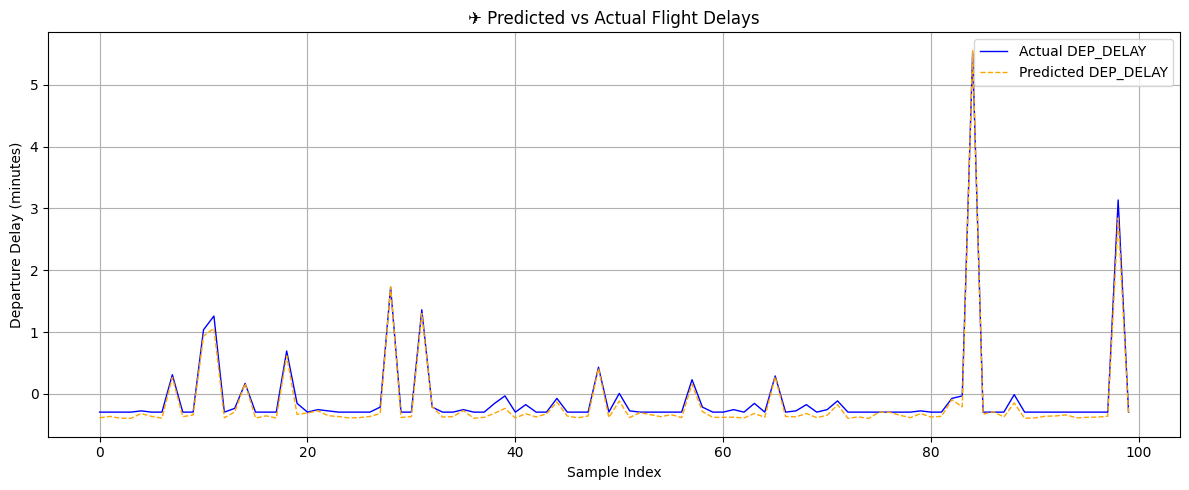

In [24]:
import matplotlib.pyplot as plt

# === Ensure model is in eval mode and get predictions on test set ===
model.eval()
with torch.no_grad():
    y_pred = model(X_test).squeeze().cpu().numpy()
    y_true = y_test.squeeze().cpu().numpy()

# === Plot Predicted vs Actual DEP_DELAY ===
N = 100# Show only first N samples
actual = y_true[:N]
predicted = y_pred[:N]

plt.figure(figsize=(12, 5))
plt.plot(actual, label='Actual DEP_DELAY', color='blue', linewidth=1)
plt.plot(predicted, label='Predicted DEP_DELAY', color='orange', linestyle='--', linewidth=1)
plt.title("✈ Predicted vs Actual Flight Delays")
plt.xlabel("Sample Index")
plt.ylabel("Departure Delay (minutes)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
